In [2]:
import sys
sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 10)


In [3]:
# 투자자산
tickers = ['TQQQ','TMF']
# 비교자산
safe_ticker = ['BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱함
lag = 1


In [4]:
data = yf.download(tickers+safe_ticker, end='2022-12-10')['Adj Close']
data = data[tickers+safe_ticker]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()
    
start_day = assets.index.min()
print('assets \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  3 of 3 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BIL 2007-05-30 00:00:00
assets 
                  TQQQ        TMF        BIL
Date                                       
2010-02-11   0.429243   6.660957  86.303894
2010-02-12   0.431001   6.736332  86.303894
2010-02-16   0.447695   6.796631  86.303894
2010-02-17   0.455293   6.579120  86.247437
2010-02-18   0.463924   6.467136  86.285095
...               ...        ...        ...
2022-12-05  22.115219   9.182485  91.179413
2022-12-06  20.712500   9.540632  91.209328
2022-12-07  20.463791  10.177337  91.209328
2022-12-08  21.190022  10.107697  91.269150
2022-12-09  20.782137   9.331713  91.259178

[3231 rows x 3 columns]
start day :  2010-02-11 00:00:00


In [8]:
asset_monthly = assets.resample('BM').last()
print(asset_monthly)

                 TQQQ        TMF        BIL
Date                                       
2010-02-26   0.461495   7.080901  86.285095
2010-03-31   0.574943   6.604033  86.285095
2010-04-30   0.609986   7.261839  86.247437
2010-05-31   0.470592   8.462771  86.285095
2010-06-30   0.381745   9.880560  86.303894
...               ...        ...        ...
2022-08-31  27.666409  11.270869  90.522209
2022-09-30  19.220245   8.525883  90.709366
2022-10-31  20.841829   6.924171  90.853195
2022-11-30  23.438353   8.406500  91.139526
2022-12-30  20.782137   9.331713  91.259178

[155 rows x 3 columns]


In [9]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [10]:
# 벤치마크 수익율
bmk = {}
for i in range(0,2):
    bmk[i] = long_only_ew(assets[tickers[i]].to_frame(), start_day, 'bmk({})'.format(tickers[i]))
bmk_report = bt.run(*bmk.values())

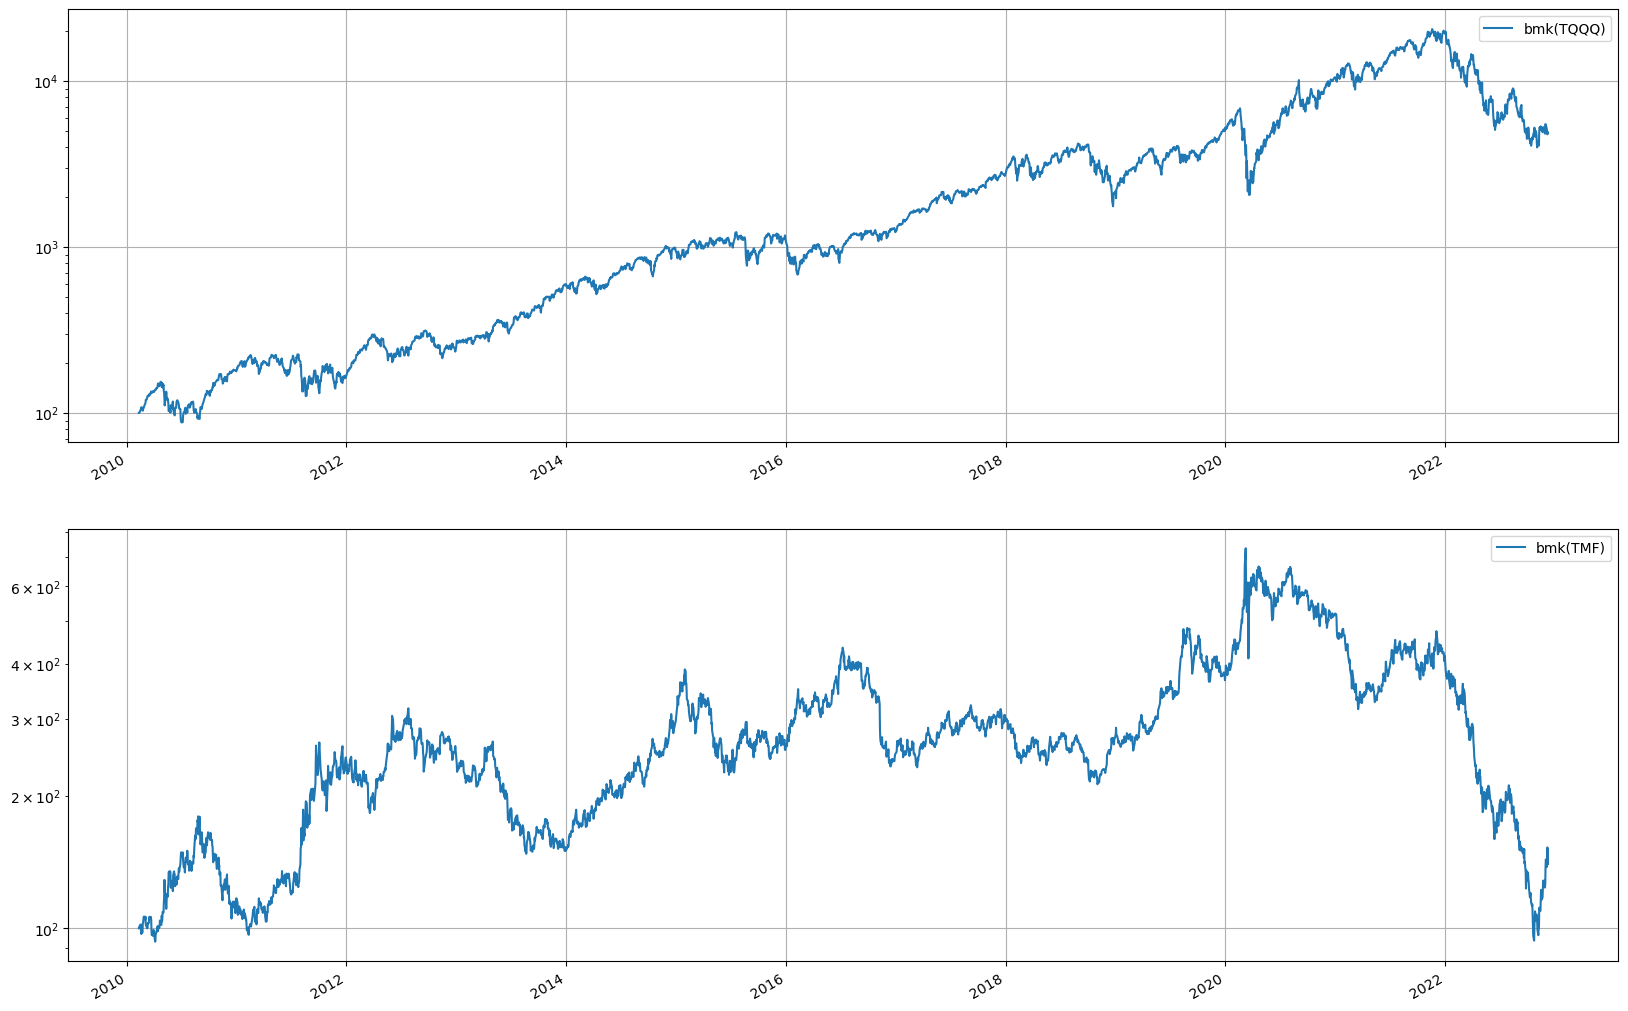

In [11]:
fig, ax = plt.subplots(2,1, figsize=(20,14))
for i in range(0,2):
    bmk_report.prices[['bmk({})'.format(tickers[i])]].plot(ax=ax[i], grid=True, logy=True)


In [12]:
#bmk_report.display()
bmk_report.prices[start_day:].calc_stats().display()

Stat                 bmk(TQQQ)    bmk(TMF)
-------------------  -----------  ----------
Start                2010-02-11   2010-02-11
End                  2022-12-09   2022-12-09
Risk-free rate       0.00%        0.00%

Total Return         4741.57%     40.10%
Daily Sharpe         0.80         0.28
Daily Sortino        1.26         0.47
CAGR                 35.33%       2.66%
Max Drawdown         -80.64%      -87.19%
Calmar Ratio         0.44         0.03

MTD                  -11.33%      11.01%
3m                   -29.99%      -8.87%
6m                   -30.34%      -24.87%
YTD                  -74.88%      -66.44%
1Y                   -74.28%      -67.29%
3Y (ann.)            3.04%        -29.16%
5Y (ann.)            12.63%       -14.28%
10Y (ann.)           34.73%       -6.34%
Since Incep. (ann.)  35.33%       2.66%

Daily Sharpe         0.80         0.28
Daily Sortino        1.26         0.47
Daily Mean (ann.)    49.43%       12.67%
Daily Vol (ann.)     61.42%       44.78%
Daily 

In [13]:
def FixedWeight_BT(asset, start_day, weights, run_on_end_of_period=False, returns=pd.DataFrame(), lag=1, ylookback=12, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.SelectAll(),
                           WeighFixed(returns, lag, ylookback, **weights),
                           #bt.algos.WeighSpecified(**weights),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, asset, initial_capital=100000000.0)      

In [15]:
init=9
fixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights[i] = FixedWeight_BT(assets[tickers], start_day, weights, False, pd.DataFrame(), 1, 0, 'FW_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_report = bt.run(*fixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

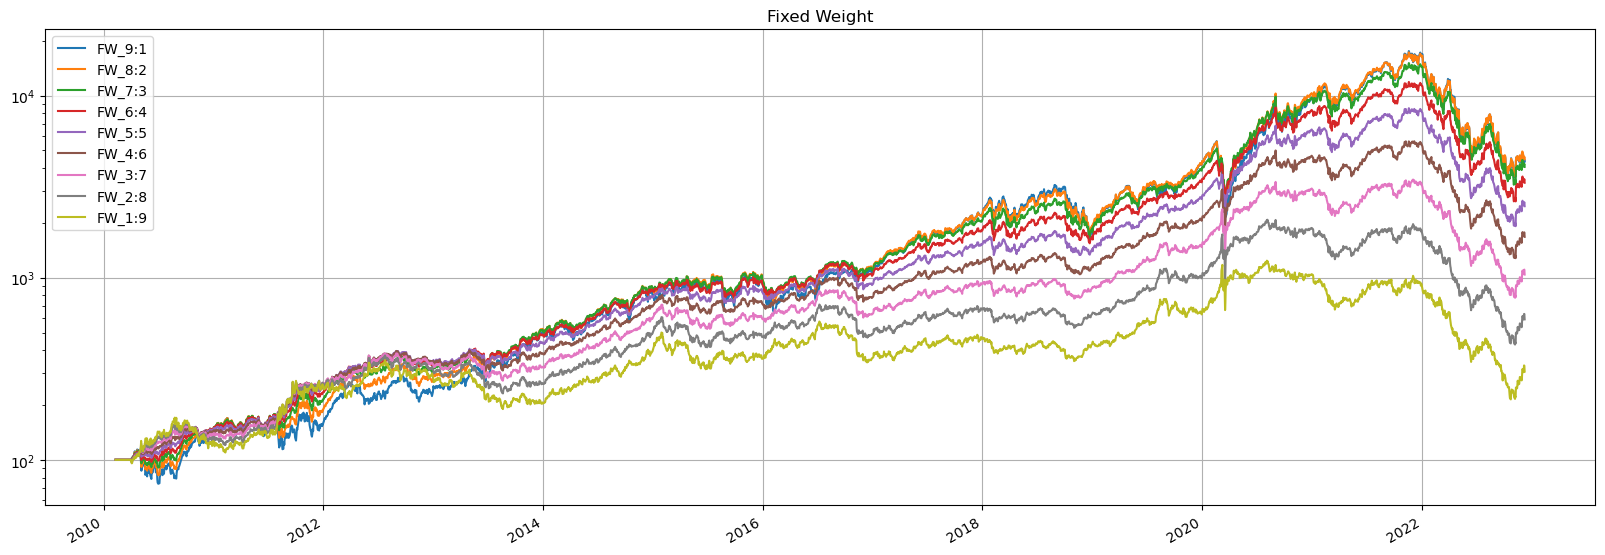

In [16]:
fw_report.plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [17]:
print(fw_report.prices[start_day:].calc_stats().display())

Stat                 FW_9:1      FW_8:2      FW_7:3      FW_6:4      FW_5:5      FW_4:6      FW_3:7      FW_2:8      FW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         4238.91%    4362.82%    3959.13%    3220.79%    2367.94%    1575.02%    940.22%     490.50%     205.22%
Daily Sharpe         0.83        0.88        0.93        0.95        0.94        0.86        0.73        0.57        0.42
Daily Sortino        1.30        1.39        1.47        1.51        1.48        1.36        1.17        0.93        0.69

In [22]:
print('drawdown \n', fw_report.backtests['FW_4:6'].stats.drawdown_details.sort_values('drawdown').head(20))
print('yearly return \n', fw_report.backtests['FW_4:6'].stats.yearly_returns)

drawdown 
                    Start                  End Length  drawdown
172  2021-12-08 00:00:00  2022-12-09 00:00:00    366 -0.771818
148  2020-03-10 00:00:00  2020-04-16 00:00:00     37  -0.42308
162  2020-09-03 00:00:00  2021-07-19 00:00:00    319 -0.313768
103  2016-09-07 00:00:00  2017-05-22 00:00:00    257 -0.260686
122  2018-08-31 00:00:00  2019-03-15 00:00:00    196 -0.235271
61   2013-05-03 00:00:00  2014-01-15 00:00:00    257 -0.226742
92   2015-02-03 00:00:00  2016-04-01 00:00:00    423 -0.210197
118  2018-01-29 00:00:00  2018-07-10 00:00:00    162 -0.191361
60   2012-09-04 00:00:00  2013-05-02 00:00:00    240 -0.167005
169  2021-09-16 00:00:00  2021-11-04 00:00:00     49 -0.164103
139  2019-09-05 00:00:00  2019-11-26 00:00:00     82 -0.122369
22   2010-11-05 00:00:00  2011-04-21 00:00:00    167 -0.121486
36   2011-09-23 00:00:00  2011-10-05 00:00:00     12 -0.107619
106  2017-06-27 00:00:00  2017-08-23 00:00:00     57 -0.099221
42   2011-11-08 00:00:00  2012-01-11 00:00:0

In [23]:
assets_cash = assets[tickers].copy()
assets_cash['SAFE'] = assets[safe_ticker[0]].copy()
print(assets_cash)

start_day = start_day + pd.DateOffset(months=12)
print('start_day : ', start_day)

                 TQQQ        TMF       SAFE
Date                                       
2010-02-11   0.429243   6.660957  86.303894
2010-02-12   0.431001   6.736331  86.303894
2010-02-16   0.447695   6.796631  86.303894
2010-02-17   0.455293   6.579120  86.247459
2010-02-18   0.463924   6.467137  86.285072
...               ...        ...        ...
2022-12-05  22.115219   9.182485  91.179413
2022-12-06  20.712500   9.540632  91.209328
2022-12-07  20.463791  10.177337  91.209328
2022-12-08  21.190022  10.107697  91.269150
2022-12-09  20.782137   9.331713  91.259178

[3231 rows x 3 columns]
start_day :  2011-02-11 00:00:00


In [25]:
# 수익률곡선 + 고정비중 투자전력
init=9
yfixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10,'SAFE':0}
    print(weights)
    returns = fw_report.prices['FW_{}:{}'.format(init,(10-init))].rebase(1).to_frame().copy()
    print('returns[FW_{}:{}]\n'.format(init, (10-init)), returns)
    yfixedWeights[i] = FixedWeight_BT(assets_cash, start_day, weights, False, returns, 1, 12, name='yFW_{}:{}'.format(init,(10-init)))
    init = init - 1
yfw_report = bt.run(*yfixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1, 'SAFE': 0}
returns[FW_9:1]
                FW_9:1
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  45.814312
2022-12-06  43.358706
2022-12-07  43.197735
2022-12-08  44.524508
2022-12-09  43.389106

[3232 rows x 1 columns]
{'TQQQ': 0.8, 'TMF': 0.2, 'SAFE': 0}
returns[FW_8:2]
                FW_8:2
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  46.756824
2022-12-06  44.714410
2022-12-07  44.914938
2022-12-08  46.086012
2022-12-09  44.628181

[3232 rows x 1 columns]
{'TQQQ': 0.7, 'TMF': 0.3, 'SAFE': 0}
returns[FW_7:3]
                FW_7:3
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  42.196905
2022-12-06  40.775959
2022-12-07  41.289151
2022-12-08  42.179371
2022-12-09  40.591

Stat                 yFW_9:1     yFW_8:2     yFW_7:3     yFW_6:4     yFW_5:5     yFW_4:6     yFW_3:7     yFW_2:8     yFW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         730.38%     1271.86%    1650.36%    1762.16%    1439.86%    1063.58%    616.90%     290.27%     131.26%
Daily Sharpe         0.65        0.80        0.93        1.02        1.02        0.96        0.83        0.60        0.41
Daily Sortino        0.97        1.22        1.42        1.57        1.57        1.48        1.28        0.94        0.6

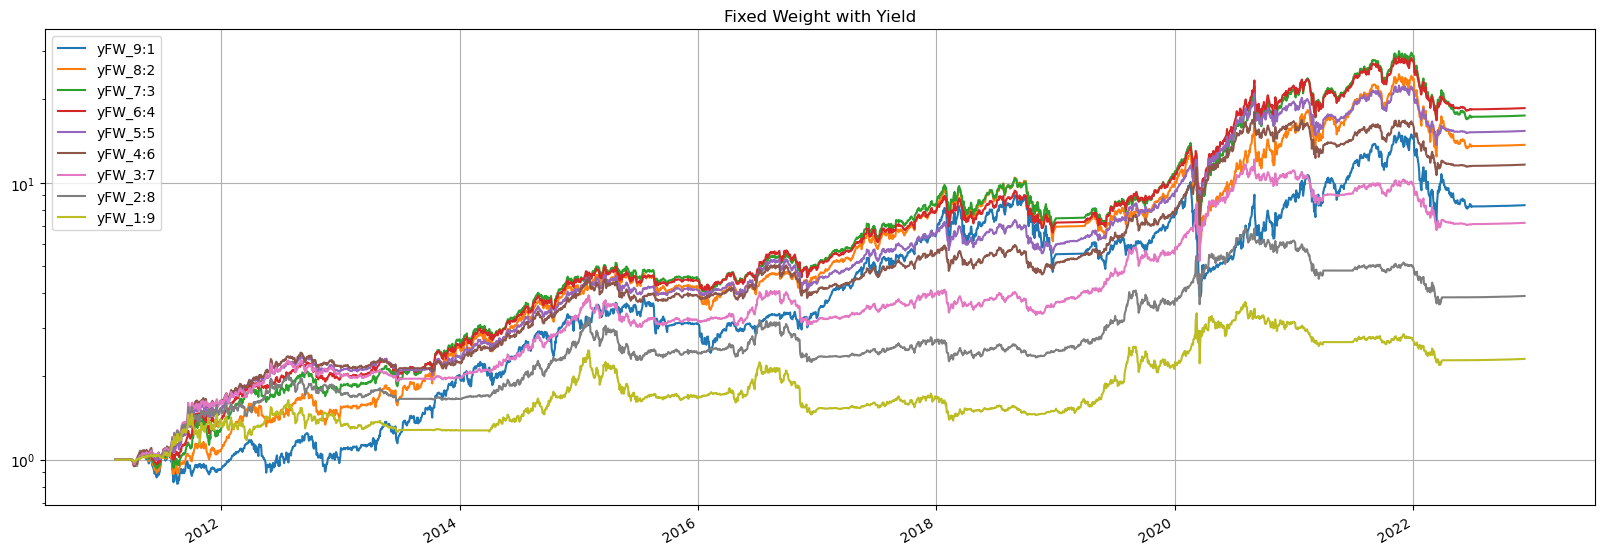

In [26]:
yfw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight with Yield")
yfw_report.prices[start_day:].calc_stats().display()

In [27]:
rolling = 126
rolling_corr = assets.rolling(rolling).corr()['TQQQ'].loc[:,'TMF'].to_frame()
print('rolling corr \n', rolling_corr)
print('start_day : ', rolling_corr['TQQQ'].first_valid_index())

rolling corr 
                 TQQQ
Date                
2010-02-11       NaN
2010-02-12       NaN
2010-02-16       NaN
2010-02-17       NaN
2010-02-18       NaN
...              ...
2022-12-05  0.806093
2022-12-06  0.803474
2022-12-07  0.799382
2022-12-08  0.796501
2022-12-09  0.797376

[3231 rows x 1 columns]
start_day :  2010-08-11 00:00:00


In [28]:
def FixedWeightWithCorr_BT(assets, start_day, weights, run_on_end_of_period=False, rolling_corr=pd.DataFrame(), cval=0.5, lag=1, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighFixedWithCorr(lag, rolling_corr, cval, **weights),
                           #bt.algos.PrintTempData(),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),                           
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=10000.0)

In [29]:
# 상관계수 + 고정비중 투자전력
init=9
cfixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10,'SAFE':0}
    print(weights)
    cfixedWeights[i] = FixedWeightWithCorr_BT(assets_cash, start_day, weights, False, rolling_corr, 0.5, 1, name='cFW_{}:{}'.format(init,(10-init)))
    init = init - 1
cfw_report = bt.run(*cfixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1, 'SAFE': 0}
{'TQQQ': 0.8, 'TMF': 0.2, 'SAFE': 0}
{'TQQQ': 0.7, 'TMF': 0.3, 'SAFE': 0}
{'TQQQ': 0.6, 'TMF': 0.4, 'SAFE': 0}
{'TQQQ': 0.5, 'TMF': 0.5, 'SAFE': 0}
{'TQQQ': 0.4, 'TMF': 0.6, 'SAFE': 0}
{'TQQQ': 0.3, 'TMF': 0.7, 'SAFE': 0}
{'TQQQ': 0.2, 'TMF': 0.8, 'SAFE': 0}
{'TQQQ': 0.1, 'TMF': 0.9, 'SAFE': 0}


Stat                 cFW_9:1     cFW_8:2     cFW_7:3     cFW_6:4     cFW_5:5     cFW_4:6     cFW_3:7     cFW_2:8     cFW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-10  2010-02-10  2010-02-10  2010-02-10  2010-02-10  2010-02-10  2010-02-10  2010-02-10  2010-02-10
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         5537.93%    5627.85%    5142.31%    4284.36%    3283.54%    2318.91%    1507.60%    890.38%     464.31%
Daily Sharpe         0.91        1.00        1.07        1.12        1.13        1.06        0.92        0.74        0.57
Daily Sortino        1.41        1.55        1.67        1.76        1.76        1.66        1.45        1.18        0.9

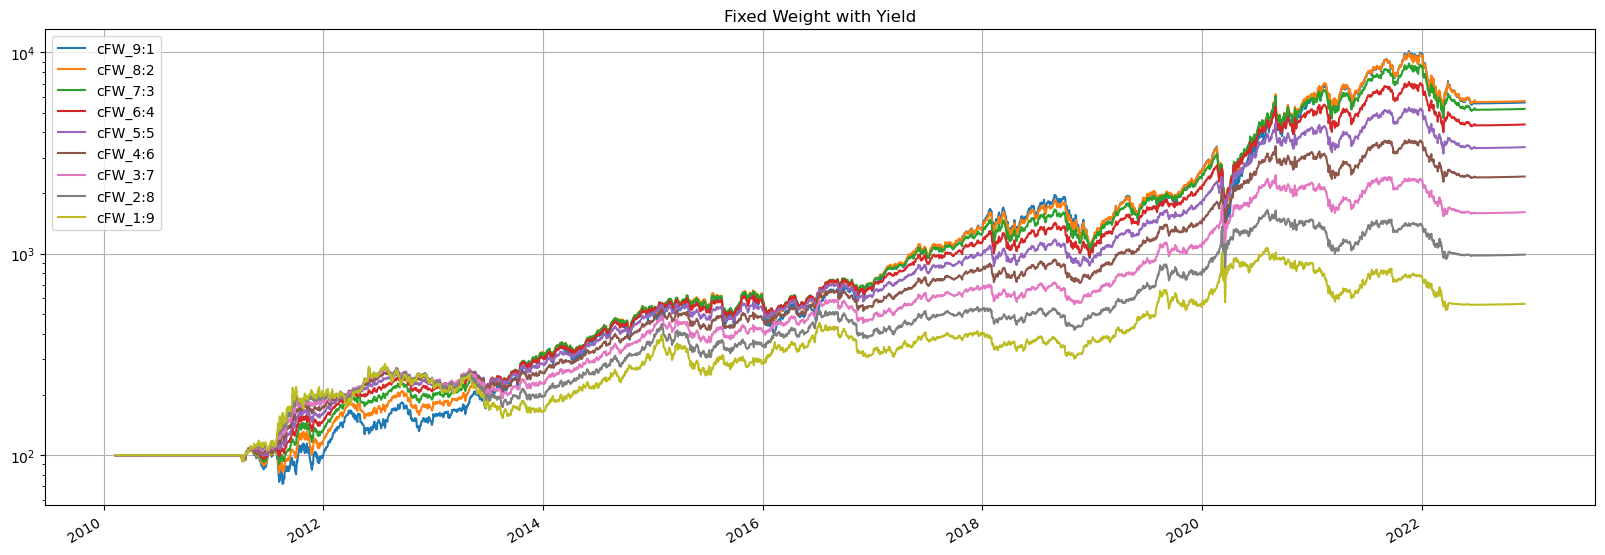

In [30]:
cfw_report.plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight with Yield")
cfw_report.prices.calc_stats().display()

In [23]:
cfw_report.get_transactions('cFW_5:5')

price  quantity
Date       Security                     
2010-04-01 TMF        6.577304     760.0
           TQQQ       0.576784    8668.0
2010-07-01 TMF        9.975431    -215.0
           TQQQ       0.379986    5644.0
2010-10-01 TMF       10.747918     104.0
...                        ...       ...
2022-04-01 SAFE      90.492523    5275.0
           TMF       19.563517  -15455.0
           TQQQ      57.930000   -3020.0
2022-07-01 SAFE      90.575676     443.0
           TQQQ      24.389999   -1648.0

[111 rows x 2 columns]

<AxesSubplot:>

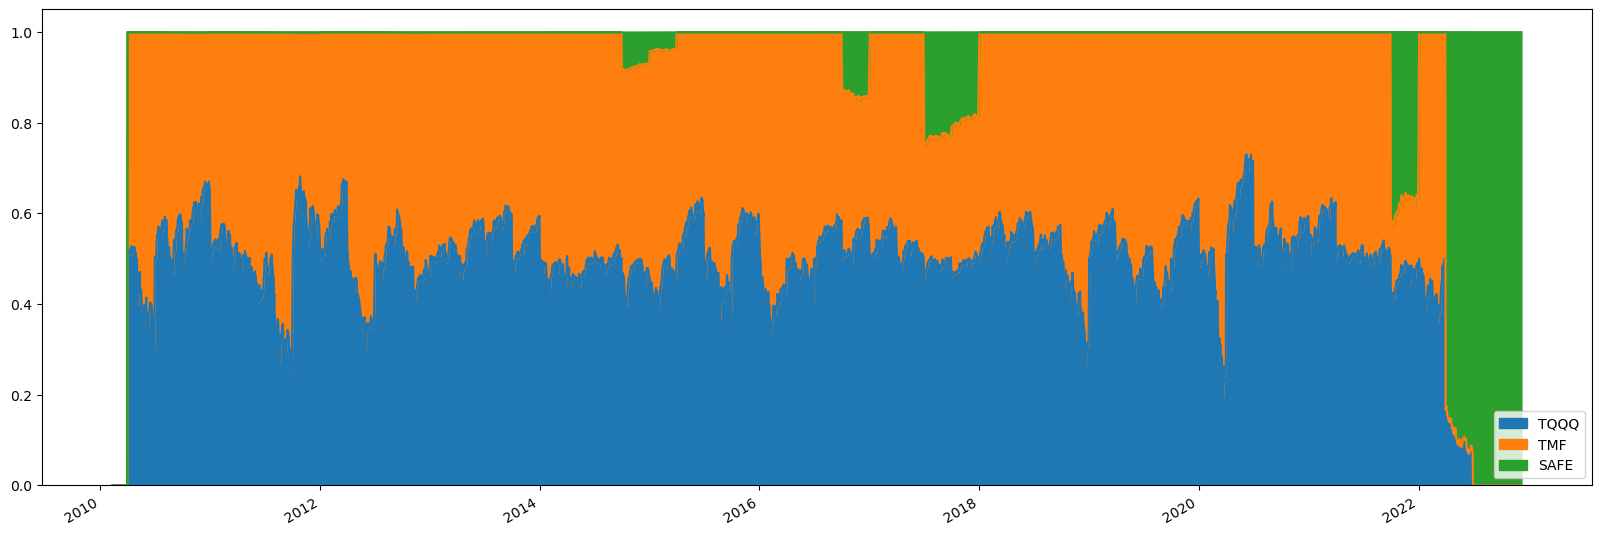

In [24]:
cfw_report.get_security_weights('cFW_5:5').plot.area(figsize=(20,7))